# Keras迁移学习之--如何用很少的图片数据集来训练高可用的分类模型

关于『迁移学习』在上一篇文章中也有讲过，可以看一下我的上一篇文章[使用 Google Inception V3模型进行迁移学习](使用 Google Inception V3模型进行迁移学习.ipynb)

本篇文章我们主要探讨以下内容:
1. 用少量的图片来训练一个神经网络
2. 使用 『bottleneck feature』(网络在全连接之前的最后一层激活的feature map)
3. 使用 『fine-tune』迁移学习
4. VGG16 网络模型

同时我们将用到**Keras**中的以下特性:
- `fit_generator` 来进行模型的训练
- `ImageDataGenerator` 时时增加数据集
- layer freezing and model fine-tuning
- ...

# 【目录】
- [1.关于数据集](#1.关于数据集)
    - [1.2 制作自己的数据集](#1.2-制作自己的数据集)
- [2.创建VGG16网络模型](#2.创建VGG16网络模型)   
    - [2.1 创建VGG16网络模型](#2.1-创建VGG16网络模型)
    - [2.2 保存bottleneck features](#2.2-保存bottleneck-features)
- [3.使用bottleneck features](#3.使用bottleneck-features)   
- [4.使用训练的VGG16网络模型预测](#4.使用训练的VGG16网络模型预测)


# 1.关于数据集

我们将使用 [Cats & Dogs in Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data)的数据集，但我们只用 1000张(Cats 1000 and Dogs 1000), 源数据集有12500 张Cats and 12500张Dogs.
大体的数据集构造如下:

```
 train/
     |-- cats (1000 samples)
         |-- cat_001.jpg
         |-- cat_002.jpg
         |-- cat_...
     |-- dogs (1000 samples)
         |-- dog_001.jpg
         |-- dog_002.jpg
         |-- dog_...
 validation/
     |-- cats (400 samples)
         |-- cat_001.jpg
         |-- cat_002.jpg
         |-- cat_...
     |-- dogs (400 samples)
         |-- dog_001.jpg
         |-- dog_002.jpg
         |-- dog_...         
``` 

*注:*
你也可以通过以下两个链接下载
1. [Kaggle Dogs and Cats Train_and_Test DataSet 百度盘下载](https://pan.baidu.com/s/1DH0Mquku62MMOx-U-Gcczw) 提取码: 3nk9
2. 你也可以下载已经处理好的数据集[百度盘下载](https://pan.baidu.com/s/1pZbSYJzXgWEty0FBhMelnQ) 提取码: t7k4

## 1.2 制作自己的数据集

In [1]:
#源数据集的path
ORIGINAL_DATA_PATH='../data/dog_cat_train/'
# 制作的数据集存放路径
GEN_DATA_PATH='../data/my-dataset-images/dogs_cats/'

In [56]:
from __future__ import print_function
import os
import glob

In [46]:
cat_img_filenames = glob.glob(os.path.join(ORIGINAL_DATA_PATH, 'cat*.jpg'))
dog_img_filenames = glob.glob(os.path.join(ORIGINAL_DATA_PATH, 'dog*.jpg'))

print('cats vs dogs:', len(cat_img_filenames), len(dog_img_filenames))

cats vs dogs: 12500 12500


In [3]:
import numpy as np
from shutil import copyfile, rmtree

def load_data(path, des_path, phase='train', d_size=1000, shuffle=True):
    cat_img_filenames = glob.glob(os.path.join(path, 'cat*.jpg'))
    dog_img_filenames = glob.glob(os.path.join(path, 'dog*.jpg'))
    
    if shuffle:
        np.random.shuffle(cat_img_filenames)
        np.random.shuffle(dog_img_filenames)
            
    d_sized_cats = cat_img_filenames[:d_size]
    d_sized_dogs = dog_img_filenames[:d_size]
    
    cat_des_path = os.path.join(des_path, phase, 'cats')
    dog_des_path = os.path.join(des_path, phase, 'dogs')    
    
    if not os.path.exists(cat_des_path):
        os.makedirs(cat_des_path)
        
    if not os.path.exists(dog_des_path):
        os.makedirs(dog_des_path)        
    
    for cat_f in d_sized_cats:
        basename = os.path.basename(cat_f)
        copyfile(cat_f, os.path.join(cat_des_path, basename))
    
    for dog_f in d_sized_dogs:
        basename = os.path.basename(dog_f)
        copyfile(dog_f, os.path.join(dog_des_path, basename))
     
    
def load_cats_and_dogs_dataset(path, des_path, shuffle=True):
    if os.path.exists(des_path):
        rmtree(des_path)
    
    load_data(path, des_path, phase='train', d_size=1000)
    load_data(path, des_path, phase='validation', d_size=400)     

生成数据集

In [37]:
load_cats_and_dogs_dataset(ORIGINAL_DATA_PATH, GEN_DATA_PATH)  

In [44]:
import subprocess

print(subprocess.check_output(('ls -l %s' % GEN_DATA_PATH).split()))

total 0
drwxr-xr-x  4 yongliu  staff  136 Jun  4 11:49 train
drwxr-xr-x  4 yongliu  staff  136 Jun  4 11:49 validation



# 2.创建VGG16网络模型

VGG16层网络模型如下图所示 
![](../data/images/vgg16_original.png)

## 2.1 创建VGG16网络模型

In [6]:
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from keras.applications import VGG16
import numpy as np
import warnings
warnings.filterwarnings('ignore')

model = VGG16(weights='imagenet', include_top=False)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [100]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=(150, 150,3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D((2,2), padding='same'))

model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model2.add(Dense(64))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_12 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 64)        18496     
__________

使用 `ImageDataGenerator`来增强网络

In [7]:

batch_size=16

datagen = ImageDataGenerator(
     rescale=1./255,
     shear_range=0.2,
     zoom_range=0.2,
     horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(directory=os.path.join(GEN_DATA_PATH, 'train'), 
                                              batch_size=batch_size, 
                                              target_size=(150, 150), 
                                              class_mode='binary', 
                                              shuffle=False)

validation_generate = test_datagen.flow_from_directory(directory=os.path.join(GEN_DATA_PATH, 'validation'), 
                                                  batch_size=batch_size, 
                                                  target_size=(150,150), 
                                                  class_mode='binary',
                                                  shuffle=False)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## 2.2 保存bottleneck features

In [9]:
# 保存bottleneck features
bottleneck_train_features = model.predict_generator(generator=train_generator, steps=2000//batch_size)
np.save(open('../data/models/cats_and_dogs_train_bottleneck_features.npy', 'w'), bottleneck_train_features)
print('The train bottlenect feature saved Done!')

bottleneck_val_features = model.predict_generator(generator=validation_generate, steps=800//batch_size)
np.save(open('../data/models/cats_and_dogs_validation_bottleneck_features.npy', 'w'), bottleneck_val_features)
print('The validation bottlenect feature saved Done!')


The train bottlenect feature saved Done!
The validation bottlenect feature saved Done!


# 3.使用bottleneck features

In [92]:
import numpy as np
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import SGD, RMSprop
from keras.models import Sequential

train_data = np.load(open('../data/models/cats_and_dogs_train_bottleneck_features.npy'))
train_labels = np.array([0]*1000 + [1]*1000)

validation_data = np.load(open('../data/models/cats_and_dogs_validation_bottleneck_features.npy'))
validation_labels = np.array([0]*400 + [1]*400)

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 257       
Total params: 8,652,289
Trainable params: 8,652,289
Non-trainable params: 0
_________________________________________________________________


In [10]:
print(train_data.shape)
print(validation_data.shape)

(2000, 4, 4, 512)
(800, 4, 4, 512)


In [93]:
np_epoches = 30
pred_model = model.fit(train_data, 
                 train_labels, 
                 epochs=np_epoches, 
                 batch_size=16, 
                 validation_data=(validation_data, validation_labels))

Train on 2000 samples, validate on 800 samples
Epoch 1/30
2000/2000 [==============================] - 11s 6ms/step - loss: 0.5729 - acc: 0.7115 - val_loss: 0.3696 - val_acc: 0.8325
Epoch 2/30
2000/2000 [==============================] - 12s 6ms/step - loss: 0.4088 - acc: 0.8210 - val_loss: 0.3033 - val_acc: 0.8662
Epoch 3/30
2000/2000 [==============================] - 10s 5ms/step - loss: 0.3612 - acc: 0.8465 - val_loss: 0.3031 - val_acc: 0.8638
Epoch 4/30
2000/2000 [==============================] - 10s 5ms/step - loss: 0.3278 - acc: 0.8625 - val_loss: 0.2760 - val_acc: 0.8762
Epoch 5/30
2000/2000 [==============================] - 10s 5ms/step - loss: 0.2788 - acc: 0.8820 - val_loss: 0.2934 - val_acc: 0.8788
Epoch 6/30
2000/2000 [==============================] - 10s 5ms/step - loss: 0.2497 - acc: 0.8955 - val_loss: 0.2889 - val_acc: 0.8825
Epoch 7/30
2000/2000 [==============================] - 10s 5ms/step - loss: 0.2314 - acc: 0.9055 - val_loss: 0.2823 - val_acc: 0.8862
Epoch 8/

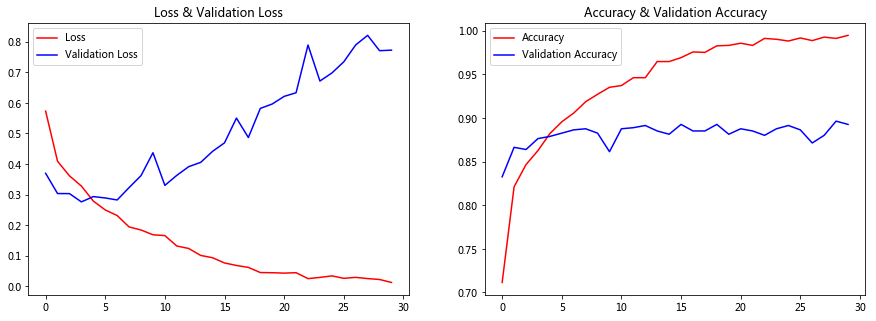

In [94]:
# accuracy = pred_model.history['acct']
loss = pred_model.history['loss']
val_loss = pred_model.history['val_loss']

acc = pred_model.history['acc']
val_acc = pred_model.history['val_acc']

import matplotlib.pyplot as plt
%matplotlib inline


x = range(np_epoches)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(x, loss, c='red', label='Loss')
plt.plot(x, val_loss, c='blue', label='Validation Loss')
plt.title('Loss & Validation Loss')
plt.legend()

plt.subplot(122)
plt.plot(x, acc, c='red', label='Accuracy')
plt.plot(x, val_acc, c='blue', label='Validation Accuracy')
plt.legend()
plt.title('Accuracy & Validation Accuracy')

plt.show()


经过20 epoches, `Validation Accuracy` 达到了90%以上, 效果还是不错的，关键是模型`fit`的速度非常快!!

In [120]:
# 保存模型
model.save('../data/models/cats_dogs_acc_90.h5')

# 4.使用训练的VGG16网络模型预测

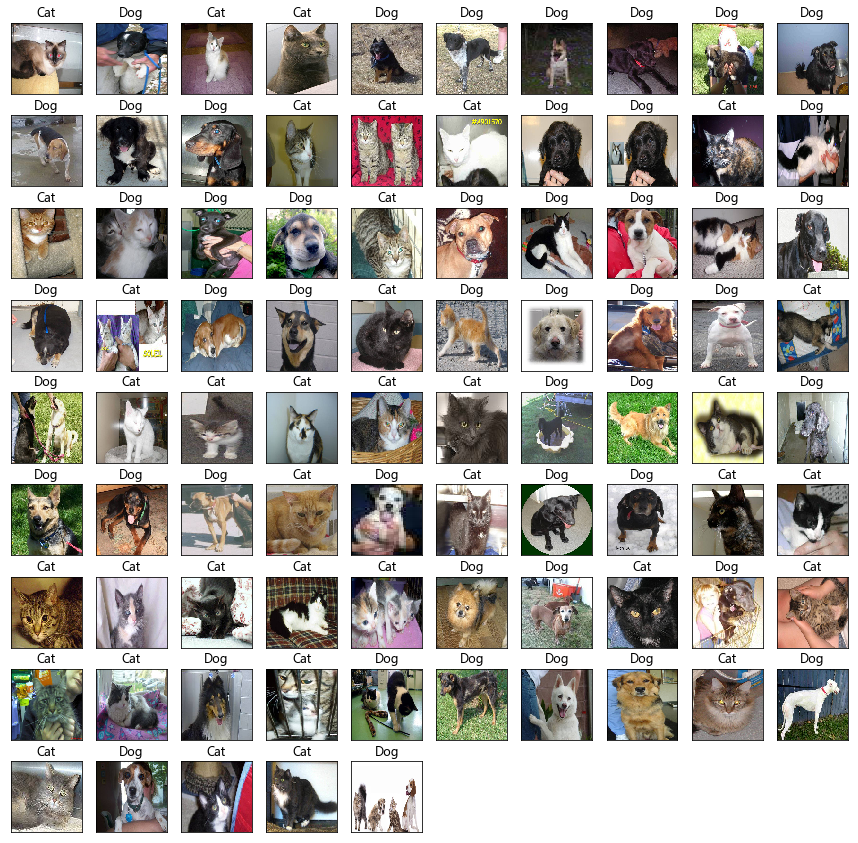

In [138]:
from keras.applications import VGG16
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

import math
import matplotlib.pyplot as plt
%matplotlib inline

labels = {
    0: 'Cat', 
    1: 'Dog'
}

Test_PATH='../data/my-dataset-images/dogs_cats/test/'


modelVGG = VGG16(weights='imagenet', include_top=False)
 
# 加载我们训练好的模型    
myModel = load_model('../data/models/cats_dogs_acc_90.h5')

test_files = []
img_pattens = ['*.jpg', '*.png']
for patten in img_pattens:
    test_files.extend(glob.glob(os.path.join(Test_PATH, patten)))

count = len(test_files)

# 每行显示多少张图片
num_of_disp_per_row = 10
# 共有多少行
rows = math.ceil(count/float(num_of_disp_per_row))


plt.figure(figsize=(15,15))

for i,f in enumerate(test_files):
    img = load_img(f, target_size=(150, 150))
    x = img_to_array(img) # (150, 150, 3) 三维的
    x = np.expand_dims(x, axis=0) # (1, 150, 150, 3)， 在行上加1维，就变成了4维
    x = preprocess_input(x) # 预处理数据
    features = modelVGG.predict(x) # (1, 4, 4, 512)
    
    scores = myModel.predict_proba(features)
    lable = labels[int(scores.flatten()[0])]
    
    ax = plt.subplot(rows, num_of_disp_per_row, i+1)
    plt.imshow(img)
    plt.title(lable)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

从上面的结果来看，预测的效果还是非常不错的！！！


# 【总结】
- 了解了VGG16网络模型 (include_top and notop模型)
   - include_top 是包含了最后一层 (全连接层及`softmax`层，1000个分类)
   - notop 也就是没有最后一层，是转门用作*迁移学习的*
- 如何用少量的数据来训练高可用的模型
- 在做预测时，因为用load_img方法来加载图片没有写target_size=(150,150)导致无论如何也运行不了，以后得注意自己定义的网络模型允许的输入图片的size, 在做预测时一定要与之匹配，否则都不知道哪里出来错！！
- 对于一张图片上既有"猫" 又有 "狗"用该模型只能识别出一种出来，至于是哪一种，就得以特征多少来！(谁的特征多，就显示谁)
-----
【参考】
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- http://www.zhimengzhe.com/bianchengjiaocheng/qitabiancheng/304922.html